<a href="https://colab.research.google.com/github/faustmann/covid-19_wave_signals/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

In [ ]:
def get_positive_edge(boolean_series):
    return boolean_series.diff() & boolean_series


def bang_bang_control(trend_ind_series):
    state = False
    state_series = []
    for index, row in trend_ind_series.iterrows():
        if row['rising_ind']:
            state = True
        if row['falling_ind']:
            state = False
        state_series.append(state)

    return pd.Series(state_series)

In [ ]:
global_ds = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv')
global_ds['dateRep'] = pd.to_datetime(global_ds.dateRep, format='%d/%m/%Y')
global_ds = global_ds.drop(labels=['day', 'month', 'year'], axis=1)

countries_grouped_ds = [(country_name, country_ds) for country_name, country_ds
                        in global_ds.groupby('countriesAndTerritories')
                        if country_name in ['Croatia', 'Austria', 'United_States_of_America']]

Austria


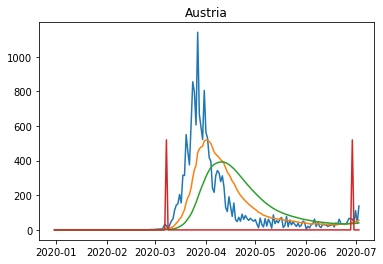

Croatia


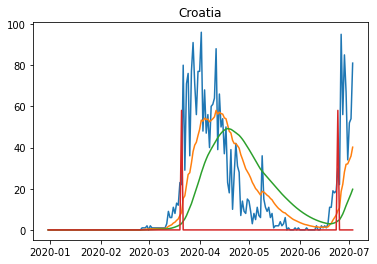

United_States_of_America


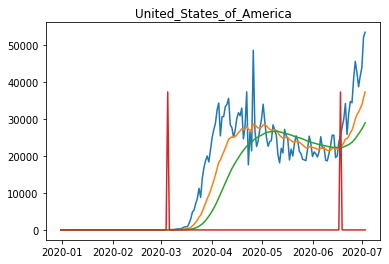

In [ ]:
for country_name, country_ds in countries_grouped_ds:
    country_ds.sort_values(by='dateRep', inplace=True)

    index_list = np.arange(len(country_ds['cases']))
    country_ds['rolling_mean'] = country_ds['cases'].ewm(span=20, adjust=False).mean()
    country_ds['rolling_rolling_mean'] = country_ds['rolling_mean'].ewm(span=20, adjust=False).mean()

    peak_indices, _ = find_peaks(country_ds['rolling_rolling_mean'], prominence=5)

    diff_mean = (country_ds['rolling_mean'] - (country_ds['rolling_rolling_mean']))
    trend_ind = pd.DataFrame(data={'rising_ind': (diff_mean > 5), 'falling_ind': (diff_mean < 0)})

    positive_edge_trend = get_positive_edge(bang_bang_control(trend_ind))

    print(country_name)

    plt.plot(country_ds['dateRep'], country_ds['cases'])
    plt.plot(country_ds['dateRep'], country_ds['rolling_mean'])
    plt.plot(country_ds['dateRep'], country_ds['rolling_rolling_mean'])
    plt.plot(country_ds['dateRep'], positive_edge_trend * np.max(country_ds['rolling_mean']))

    if peak_indices.shape[0] != 0:
        country_ds['max'] = country_ds['rolling_rolling_mean'][np.isin(index_list, peak_indices)]
        # plt.scatter(country_ds['dateRep'], country_ds['max'], c='g')
    plt.title(country_name)
    plt.show()
